### Objective

In this notebook, we create a simple demo to showcase the concept of role-playing dual-chatbot for digesting ABB Review articles.

### 1. Import libraries

In [1]:
from chatbot import JournalistBot, AuthorBot
from embedding_engine import Embedder
from topic_classifier import TopicClassifier
import utilities
from pdf2image import convert_from_path
import azure.cognitiveservices.speech as speechsdk
from pydub import AudioSegment
import PyPDF2
import os

import ipywidgets as widgets
from IPython.display import display, HTML, IFrame, Audio, clear_output

C:\Users\Shuai\anaconda3\envs\llm\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


We consider 4 issues of ABB Review

In [2]:
filenames = {
    'ABB Review 2022-03': 'ABB Review_03_2022_layout complete_EN_72-200dpi.pdf',
    'ABB Review 2023-01': 'ABB Review_01_2023_layout complete_EN_72-300dpi.pdf',
    'ABB Review 2023-02': 'ABB Review_02_2023_layout complete_EN_72-300dpi.pdf',
    'ABB Review 2023-03': 'ABB Review_03_2023_layout complete_EN_300dpi.pdf',
}

### 2. User journey

We instantiate an empty dictionary to store user selections.

In [3]:
user_journey = {}

#### 2.1 User selects journal issue 

In [4]:
# Create radio buttons for the journal issues
journal_issues = ['ABB Review 2022-03', 'ABB Review 2023-01', 
                  'ABB Review 2023-02', 'ABB Review 2023-03']

# User selection
issue_buttons = widgets.RadioButtons(
    options=journal_issues,
    value=None,  
    description='',
    disabled=False
)

output = widgets.Output()

# Display UI elements
display(HTML('<span style="font-weight:bold; font-size:18px;">Journal Issues:</span>'))
display(widgets.HBox([issue_buttons, output]))

# Function to display the first page of the selected journal
def show_journal_cover(journal_name):  
    file_path = os.path.join("./papers", filenames[journal_name])
    
    # Convert the first page of the PDF to an image
    images = convert_from_path(file_path, first_page=1, last_page=1, size=(300, None))
    
    # Clear the previous image
    output.clear_output()

    # Display the new image
    with output:
        display(images[0])

# Function to update and display the selected value
def on_value_change(change):
    if change['new'] in filenames:
        user_journey["selected_journal"] = filenames[change['new']]
        show_journal_cover(change['new'])

# Set up an observer to watch for changes
issue_buttons.observe(on_value_change, names='value')

#### 2.2 User selects article

We first extract articles in the user-selected issue.

In [5]:
articles = utilities.extract_articles(user_journey["selected_journal"])
print(articles)

[{'start_page': 5, 'title': 'Editorial', 'subtitle': '', 'length': 5}, {'start_page': 10, 'title': 'For greater results', 'subtitle': 'High Speed Alignment – visual servoing technology for ultra- high precision assembly', 'length': 8}, {'start_page': 18, 'title': 'The right moves', 'subtitle': 'Software that optimizes robot performance', 'length': 6}, {'start_page': 24, 'title': 'The DCS of tomorrow', 'subtitle': 'Envisioning the future of process automation', 'length': 6}, {'start_page': 30, 'title': 'Safe cyber space', 'subtitle': 'ABB Ability™ Cyber Security Workplace', 'length': 6}, {'start_page': 36, 'title': 'The virtues of  virtualization', 'subtitle': 'Virtual protection and control for medium-  voltage substations', 'length': 6}, {'start_page': 42, 'title': 'Health monitor', 'subtitle': 'Better service decisions with ABB Ability™ Smart Master', 'length': 4}, {'start_page': 46, 'title': 'Access is everything', 'subtitle': 'Opening the door to a world of information', 'length': 

We then present the article list for users to select

In [6]:
article_widgets = []

def toggle_handler(change, article, button):
    if change['new']:  # Only act on the 'toggle on' action
        user_journey["selected_article"] = article
        # Deselect all other buttons
        for other_button in all_buttons:
            if other_button != button:
                other_button.value = False

all_buttons = []  # List to store all toggle buttons

for article in articles:
    title_button = widgets.ToggleButton(
        value=False,
        description=article['title'],
        tooltip=article['title'],
        button_style='',
        layout=widgets.Layout(width='90%')
    )
    subtitle_label = widgets.Label(
        value=article['subtitle'],
        layout=widgets.Layout(margin='0 0 20px 25px')  # Bottom margin added
    )
    
    # Attach the handler to the toggle button's value change event
    title_button.observe(lambda change, article=article, button=title_button: toggle_handler(change, article, button), names='value')
    all_buttons.append(title_button)
    
    # Group the button and label in a vertical box (VBox)
    group = widgets.VBox([title_button, subtitle_label])
    article_widgets.append(group)

# Layout the grouped widgets in a two-column grid
grid = widgets.GridBox(article_widgets, layout=widgets.Layout(grid_template_columns="repeat(2, 50%)"))

# Add a title label
title_label = widgets.HTML(value='<span style="font-size: 18px; font-weight: bold;">List of Articles:</span>', layout=widgets.Layout(margin='0 0 10px 0'))


display(title_label, grid)

HTML(value='<span style="font-size: 18px; font-weight: bold;">List of Articles:</span>', layout=Layout(margin=…

GridBox(children=(VBox(children=(ToggleButton(value=False, description='Editorial', layout=Layout(width='90%')…

We can also present the original PDF to the user.

In [7]:
def split_pdf(input_pdf_path, output_pdf_path, start_page, end_page):
    """Extracts a range of pages from a PDF and saves it as a new PDF.
    """
    with open(input_pdf_path, 'rb') as source_pdf:
        pdf_reader = PyPDF2.PdfReader(source_pdf)
        pdf_writer = PyPDF2.PdfWriter()
        
        for page_num in range(start_page, end_page + 1):
            page = pdf_reader.pages[page_num-1]
            pdf_writer.add_page(page)
        
        with open(output_pdf_path, 'wb') as output_pdf:
            pdf_writer.write(output_pdf)

In [8]:
# Extract selected PDF
split_pdf(input_pdf_path="./papers/"+user_journey['selected_journal'],
         output_pdf_path="./papers/temp.pdf",
         start_page=user_journey['selected_article']['start_page'],
         end_page=user_journey['selected_article']['start_page']+user_journey['selected_article']['length']-1)

# Display selected article
display(IFrame("./papers/temp.pdf", width=1000, height=600))

#### 2.3 Topic classification

Once the article is selected, we can run a topic classification to determine the relevant topics.

In [9]:
themes = {
        
    'Tech and product insights': {
        'description': 'Spotlight on new tech and product',
        'target audience': 'R&D engineers',
        
    },
    
    'Market dynamics': {
        'description': 'Explore the market implications',
        'target audience': 'marketing professionals',
    },
    
    'Operational transformation': {
        'description': 'Insights on optimized processes and operations',
        'target audience': 'operational experts & managers',
    },
    
    'Sustainability initiatives': {
        'description': "ABB's contributions to environmental sustainability",
        'target audience': 'sustainability officers',
    },
    
    'Customer experience': {
        'description': "Dive into the end-user benefits and experiences",
        'target audience': 'customers',
    },
    
    'Industry challenges and opportunities': {
        'description': "Peering into hurdles and growth areas",
        'target audience': 'business developers',
    },
    
    'Strategic collaborations': {
        'description': "Highlighting strategic partnerships",
        'target audience': 'partnership managers',
    },
    
    'Strategy innovation': {
        'description': "Unpacking ABB's approaches to business strategies",
        'target audience': 'executives',
    },
    
    'General overview': {
        'description': "A holistic breakdown of the article's key themes",
        'target audience': 'general public',
    }
}

In [10]:
# Extract metadata
issue_name = user_journey['selected_journal']
start_page = user_journey['selected_article']['start_page']
end_page = user_journey['selected_article']['start_page'] + user_journey['selected_article']['length'] - 1

# Initialize metadata
clf = TopicClassifier(issue=issue_name, page_num=[start_page, end_page])
relevant_topics = clf.classifier(topic_list=list(themes.keys())[:-1], desired_max=5, verbose=True)
print(relevant_topics)

Processing 1/6th docs.
Processing 3/6th docs.
Processing 5/6th docs.
{'Tech and product insights': {'vote': 5.0, 'reason': ['Reason - The text is discussing carbon emissions from EV battery production and use.', 'Reason - The text provides an in-depth study of two passenger vehicles of similar size for comparison and does an analysis of battery production and the emissions resulting from it.', 'The text discusses the comparison of ICE fuel and exhaust emissions and BEV electricity use and emissions from battery manufacture.', 'Reason - The text provides information about the main energy consumers of battery production, the emissions of ICE and BEV vehicles, and the contributions to emissions during the life cycle of a passenger car.', 'reason - Examining CO₂ emissions (g/km), CO₂ emission intensity (gCO₂/kWh), battery production, car production, electric energy chain, well-to-tank, and direct emission.', 'Lower BEV emissions come from declines in grid emissions, mostly brought about by

We display the topic options for user to choose

In [11]:
user_journey["selected_topics"] = []

# Helper function for colored boxes
def colored_boxes(relevance):
    full_boxes = int(relevance)  # Number of fully filled boxes
    partial_box = relevance - full_boxes  # Fractional part for partially filled boxes
    
    full_box_html = '<span style="background-color:blue; margin-right:3px; display:inline-block; width:10px; height:10px;"></span>'
    partial_box_html = '<span style="background-color:blue; margin-right:3px; display:inline-block; width:{}px; height:10px;"></span>'.format(partial_box * 10)
    
    return widgets.HTML(''.join([full_box_html for _ in range(full_boxes)]) + \
                        (partial_box_html if partial_box > 0 else ''))

# Checkbox change handler
def on_checkbox_change(change, topic):
    if change['new']:  # If the checkbox is checked
        if topic not in user_journey["selected_topics"]:
            user_journey["selected_topics"].append(topic)
    else:  # If the checkbox is unchecked
        if topic in user_journey["selected_topics"]:
            user_journey["selected_topics"].remove(topic)

# Display column titles
font_size = 16  
topic_title = widgets.HTML(f'<b style="font-size:{font_size}px;">List of topics:</b>')
relevance_title = widgets.HTML(f'<b style="font-size:{font_size}px;">Relevance:</b>')
display(widgets.HBox([topic_title], layout=widgets.Layout(align_items='center')))

# Displaying the checkboxes with colored boxes
sorted_topics = dict(sorted(relevant_topics.items(), key=lambda item: item[1]['vote'], reverse=True)[:4])
for topic, relevance in sorted_topics.items():
    checkbox = widgets.Checkbox(value=False, description='', indent=False, layout=widgets.Layout(width='auto'))
    checkbox.observe(lambda change, topic=topic: on_checkbox_change(change, topic), names='value')
    
    topic_content = widgets.HBox([checkbox, widgets.HTML(f'<b>{topic}</b>')])
    hbox = widgets.VBox([topic_content, widgets.HTML(f'<i>Best for {themes[topic]["target audience"]}</i>'),
                              colored_boxes(relevance['vote'])])
    display(hbox)

# 'General overview' checkbox
general_checkbox = widgets.Checkbox(value=False, description='', indent=False, layout=widgets.Layout(width='auto'))
general_checkbox.observe(lambda change: on_checkbox_change(change, 'General overview'), names='value')

general_content = widgets.HBox([general_checkbox, widgets.HTML('<b>General overview</b>')])
general_vbox = widgets.VBox([general_content, widgets.HTML(f'<i>Best for {themes["General overview"]["target audience"]}</i>')], 
                            layout=widgets.Layout(width='250px'))
display(general_vbox)

In [12]:
# Sanity check
user_journey

{'selected_journal': 'ABB Review_02_2023_layout complete_EN_72-300dpi.pdf',
 'selected_article': {'start_page': 54,
  'title': 'Clean machine',
  'subtitle': 'Carbon emissions from EV battery production and use',
  'length': 4},
 'selected_topics': ['Tech and product insights']}

### 3 Dual-chatbot conversation

#### 3.1 Create vector store for the selected article

In [13]:
# Create embeddings
embedding = Embedder()
documents = embedding.load_n_process_document(issue="./papers/"+user_journey['selected_journal'],
                                             page={
                                                 'start': user_journey['selected_article']['start_page'],
                                                 'length': user_journey['selected_article']['length']
                                             }, debug=True)
vectorstore = embedding.create_vectorstore(store_path="./vectorstore/"+user_journey['selected_article']['title'])

# Create article summary (topic relevancy)
topic_relevance_explanation = clf.summarizer(user_journey['selected_topics'])
print(topic_relevance_explanation)

Embeddings found! Loaded the computed ones
{'Tech and product insights': '\n\nThe article is relevant to the topic of Tech and product insights because it provides an in-depth analysis of carbon emissions from EV battery production and use, comparing ICE fuel and exhaust emissions with BEV electricity use and emissions from battery manufacture. It also provides information on the main energy consumers of battery production, the emissions of ICE and BEV vehicles, and the contributions to emissions during the life cycle of a passenger car. Furthermore, it examines CO₂ emissions (g/km), CO₂ emission intensity (gCO₂/kWh), battery production, car production, electric energy chain, well-to-tank, and direct emission, and discusses the lower BEV emissions from declines in grid emissions due to decarbonization.'}


#### 3.2 Define two chatbots

In [17]:
# Create two chatbots
journalist = JournalistBot('Azure')
author = AuthorBot('Azure', vectorstore)

# Specify instruction for journalist bot
audience = [themes[topic]['target audience'] for topic in user_journey['selected_topics']]
journalist.instruct(theme=user_journey['selected_topics'], 
                    relevancy=topic_relevance_explanation,
                    audience=audience)

# Specify instruction for author bot
author.instruct(theme=user_journey['selected_topics'], audience=audience)

In [18]:
# Prompt for the journalist bot
print(journalist._specify_system_message())

You are a journalist examining ABB's developments related to Tech and product insights for R&D engineers.
        Your mission is to interview the article's author, represented by another chatbot, to extract key insights about Tech and product insights.
        
        To guide your interview, you are provided with the summary of why the theme(s) of Tech and product insights is/are relevant to this article.
        Your inquiries should align closely with the theme(s) and reasons provided.

        [Themes and relevancy]: 
        Tech and product insights: 

The article is relevant to the topic of Tech and product insights because it provides an in-depth analysis of carbon emissions from EV battery production and use, comparing ICE fuel and exhaust emissions with BEV electricity use and emissions from battery manufacture. It also provides information on the main energy consumers of battery production, the emissions of ICE and BEV vehicles, and the contributions to emissions during th

#### 3.3 Start conversation

In [19]:
# Book-keeping
question_list = []
answer_list = []
source_list = []


# Start conversation
for i in range(2):
    if i == 0:
        question = journalist.step('Start the conversation')
    else:
        question = journalist.step(answer)
    question_list.append(question)
    print("👨‍🏫 Journalist: " + question)
    
    answer, source = author.step(question)
    answer_list.append(answer)
    source_list.append(source)
    print("👩‍🎓 Author: " + answer)
    print("\n\n")

👨‍🏫 Journalist: Hi there! I understand that you recently authored an article on carbon emissions from EV battery production and use, comparing it with ICE fuel and exhaust emissions. Can you tell me more about the main tech and product insights that were covered in the article?
👩‍🎓 Author: Yes, that's correct! In our recent article, we conducted a study on the sustainability credentials of Battery Electric Vehicles (BEVs) and Internal Combustion Engine (ICE) vehicles. We compared the lifetime carbon footprint of a BEV, battery included, with that of an ICE vehicle. Specifically, we analyzed the life-cycle emissions of carbon dioxide (CO2) for the manufacturing of each vehicle, as well as fuel "well-to-tank" and exhaust emission data for the ICE. We also estimated data related to emissions from BEV battery manufacture and the lifetime electricity consumption of a BEV. 

Based on our analysis, we found that the primary contribution to emissions arises during the use phase for both ICE an

In [ ]:
# Saving the list to disk
with open("Q_list.txt", "w", encoding='utf-8') as f:
    for item in question_list:
        f.write("%s\n" % item)
        
with open("A_list.txt", "w", encoding='utf-8') as f:
    for item in answer_list:
        f.write("%s\n" % item)

### 4. Text-to-Speech 

We can leverage Microsoft Speech Service to turn the interview script into audio.

In [20]:
from audio import AudioEngine

# Preparation
journalist_voice = "en-US-JennyNeural"
author_voice = "en-US-GuyNeural"

scripts = {'questions': question_list, 'answers': answer_list}
voices = {'questions': journalist_voice, 'answers': author_voice}

# Instantiate audio engine
audience = [themes[topic]['target audience'] for topic in user_journey['selected_topics']]
audio_engine = AudioEngine(scripts=scripts, voice_names=voices, 
                           article_name=user_journey['selected_article']['title'], 
                           themes=user_journey['selected_topics'], 
                           audience=audience, LLM_engine='Azure')

In [21]:
# Synthesize speech
audio_filename = audio_engine.synthesize_speech(verbose=True)

Speech synthesized to file ./speech/intro_Clean machine.wav.
Speech synthesized to file ./speech/question_0_Clean machine.wav.
Speech synthesized to file ./speech/answer_0_Clean machine.wav.
Speech synthesized to file ./speech/question_1_Clean machine.wav.
Speech synthesized to file ./speech/answer_1_Clean machine.wav.


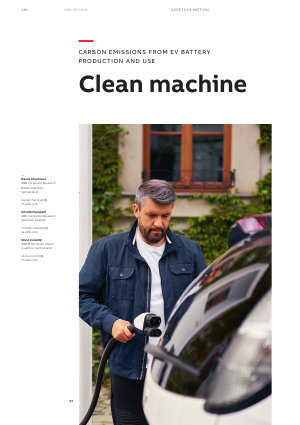

Button(description='Play Conversation', style=ButtonStyle())

In [23]:
# Article cover
images = convert_from_path('./papers/'+user_journey['selected_journal'], 
                           first_page=user_journey['selected_article']['start_page'], 
                           last_page=user_journey['selected_article']['start_page'], 
                           size=(300, None))
article_image = images[0]

# Display a play button to play the combined conversation
def play_audio(button):

    clear_output(wait=True)
    display(article_image)
    display(Audio(audio_filename))
    display(play_button)

play_button = widgets.Button(description="Play Conversation")
play_button.on_click(play_audio)

# Initial display of image and button
display(article_image)
display(play_button)